In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

# Estimate fields
- ground_truth/beam_search_lb
- Importance sampling estimate
- Hybrid estimate
- Importance sampling variance
- Hybrid variance

# General Metadata
- dataset_name
- experiment_name
- history_id
- Excluded term
- sequence_length
- history_length
- total_sequence_length

# Sampling metadata
- num_mc_samples (sub_estimates)
- sample_model_iters

# Hybrid data
- hybrid_model_iters

# Beam search metadata
- min_variance
- search_model_iters
- min_variance_reduction
- true_coverage
- restricted_coverage
- num_beams
- top_k
- top_p
- (beam search) interpolation_func


In [7]:
def get_experiment_data(experiment, dataset, h, s, root="../data", 
            methods=['beam_search_is_hybrid','importance_sampling',
                     'random_sampling','beam_search',],
            gt_methods=['ground_truth','pseudo_gt'],
            num_mc_samples = None,
            max_num_queries = None):
    
        data_dict = {}
        gt_type=None
        for method in methods:
            template_path=root + f"/{method}/{dataset}/{experiment}/"
            template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_"
            + f"{method.replace('_','-')}_{f'{h}h' if method != 'entropy_ablation' else '*'}_{s}s*"
            + f"{f'_{num_mc_samples}mc' if max_num_queries else '_'}"
            + f"{'' if method in ['beam_search_is_hybrid','entropy_ablation'] else '_model-budget'}"
            + f"{f'_{max_num_queries}q' if max_num_queries else ''}*.pkl")
            pot_pattern = os.path.join(template_path,template_file)
            pot_paths = glob.glob(pot_pattern)
            assert len(pot_paths) > 0,f"No files found for method {method} - {pot_pattern}"

            print(method, "\n",pot_paths[0],"\n=============")
            data_dict[method]= read_pkl(pot_paths[0])
            data_dict[method]['metadata']['result_filepath'] = pot_paths[0]
        gt_template_path=root + f"/ground_truth/{dataset}/{experiment}/"
        gt_template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_" +
                       f"{gt_methods[0].replace('_','-')}_{h}h_{s}s*.pkl")
        pgt_template_path=root + f"/pseudo_gt/{dataset}/{experiment}/"
        pgt_template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_" +
                       f"{gt_methods[1].replace('_','-')}_{h}h_{s}s_*"+ 
                       f"_pgt{ f'_{max_num_queries}q' if max_num_queries else ''}.pkl")
        gt_pot_pattern = os.path.join(gt_template_path,gt_template_file)
        gt_pot_paths = glob.glob(gt_pot_pattern)
        pgt_pot_pattern = os.path.join(pgt_template_path,pgt_template_file)
        print(pgt_pot_pattern)
        pgt_pot_paths = glob.glob(pgt_pot_pattern)
        # print(gt_pot_paths)
        assert (len(gt_pot_paths) == 1 and len(gt_pot_paths) < 2 )or len(pgt_pot_paths) ==1,\
            "Error, no ground truth found"
        gt_method = 'ground_truth' if len(gt_pot_paths) >0 else 'pseudo_gt'
        final_path = gt_pot_paths[0] if gt_method == "ground_truth" else pgt_pot_paths[0]
        print("GT: ", gt_method, "\n",final_path,"\n=============")
        data_dict[gt_method]= read_pkl(final_path)
        data_dict[gt_method]['metadata']['result_filepath'] = final_path
        data_dict['gt_type'] = gt_method
        return data_dict

                

In [8]:
def flatten_search(samp_dict,sub_estimates,search_type="beam_search",max_num_queries=1e10):
    samp_estimates = samp_dict['bs_lower_bound'][:max_num_queries,:len(sub_estimates)]
    if not sub_estimates:
        if len(samp_estimates.shape) ==3:
            samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
                                          samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
            assert len(samp_estimates.shape) == 1,f"Shape of bs_lower_bounds is {len(samp_estimates.shape)}"
        if len(samp_estimates.shape) ==2:
            samp_estimates = torch.gather(samp_estimates,1,
                                              samp_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
        
        df = pd.DataFrame(samp_estimates)
        df[f'{sample_type}_model_iters'] = samp_dict['model_iters']
        df[f'{sample_type}_num_beams'] = samp_dist['sample_estimate_var']
        
    else:
        assert samp_estimates.shape[1] == len(sub_estimates),\
        ("Importance sampling estimates and sub_estimates are not aligned in shape." +
         f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
        if len(samp_estimates.shape) == 2:
            samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
            beams = pd.DataFrame(samp_dict['num_beams'][:,:len(sub_estimates)],columns=sub_estimates)
            true_cov = pd.DataFrame(samp_dict['true_coverage'][:max_num_queries,:len(sub_estimates)],columns=sub_estimates)
            restr_cov = pd.DataFrame(samp_dict['restricted_coverage'][:max_num_queries,:len(sub_estimates)],columns=sub_estimates)
            model_iters = pd.DataFrame(samp_dict['model_iters'][:max_num_queries,:len(sub_estimates)],columns=sub_estimates)
            
            df_list = [
                (f'{search_type}_lb',samp_estimates),
                ('model_iters',model_iters),
                ('num_beams',beams),
                ('true_coverage',true_cov),
                ('restricted_coverage',restr_cov),
            ]
            
            for i,(name,df) in enumerate(df_list):
                df = pd.melt(df,value_vars=sub_estimates)
                df.columns = ['num_samples',name]
            # df = df_list[0]
            # for name,df in df_list[1:]:
            #     df[f'{search_type}_{name}']=df[name]
            
            # df[f'{sample_type}_variance']=var_df['variance']
            
        elif len(samp_estimates.shape) == 3:
            df_list = []
            for i in range(len(sub_estimates)):
                df = pd.DataFrame(
                            torch.gather(samp_estimates[:max_num_queries,i],1,
                                      samp_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
                        )
                df[f'{search_type}_model_iters'] = samp_dict['model_iters'][:max_num_queries,i]
                df[f'{search_type}_num_beams'] = samp_dict['num_beams'][:max_num_queries,i]
                df[f'{search_type}_true_coverage'] = samp_dict['true_coverage'][:max_num_queries,i]
                df[f'{search_type}_restricted_coverage'] = samp_dict['restricted_coverage'][:max_num_queries,i]
                # df[f'{search_type}_est_v'] = samp_dict['restricted_coverage'][:max_num_queries,i]
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=True)
        else:
            assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
    res_cols = ['lb','model_iters','num_beams','true_coverage','restricted_coverage']
    # print(df.columns, df.head())
    assert df.shape[-1] == len(res_cols), f"DF shape is {df.shape}"
    df.columns = [f'{search_type}_{s}' for s in res_cols]
    return df


def flatten_entropy(ent_dict,sub_estimates,dataset,max_num_queries=1e10):
    entropy = ent_dict['entropy_probs'][:max_num_queries]
    df_list = []
    for i in range(entropy.shape[1]):
        df = pd.DataFrame(
            entropy[:,i],
            columns = ['entropy'])
        # df['entropy'] = 10
        df['dataset_name'] = dataset
        df['sequence_id'] = list(range(df.shape[0]))
        df['num_steps'] = (i+1)
        df_list.append(df)
    return pd.concat(df_list,axis=0)



def flatten_sampling(samp_dict,sub_estimates,sample_type="importance",max_num_queries=1e10):
    if sample_type == "frequentist":
        samp_estimates = samp_dict['frequentist_estimates'][:max_num_queries,:len(sub_estimates)]
    else:
        samp_estimates = samp_dict['sample_estimates'][:max_num_queries,:len(sub_estimates)]
    if not sub_estimates:
        if len(samp_estimates.shape) ==3:
            assert samp_estimates.shape[1] == samp_dict['metadata']['num_mc_samples'],\
            (f"Error, estimate dimensions are {samp_estimates.shape} but the number of samples is " +
             f"{samp_dict['metadata']['num_mc_samples']}, which does not match")
            
            samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
                                          samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
            assert len(samp_estimates.shape) == 1,f"Shape of imp_samp_estimates is {len(samp_estimates.shape)}"
        if len(samp_estimates.shape) ==2:
            samp_estimates = torch.gather(samp_estimates,1,
                                              samp_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
        
        df = pd.DataFrame(samp_estimates)
        df.insert(0,'num_mc_samples',samp_dict['metadata']['num_mc_samples'])
        df[f'{sample_type}_model_iters'] = samp_dict['model_iters'][:max_num_queries]
        # df[f'{sample_type}_est_variance'] = samp_dist['sample_estimate_var'][:max_num_queries]
        
    else:
        assert samp_estimates.shape[1] == len(sub_estimates),\
        ("Importance sampling estimates and sub_estimates are not aligned in shape." +
         f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
        if len(samp_estimates.shape) == 2:
            samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
            # samp_var = pd.DataFrame(samp_dict['sample_estimate_var'][:max_num_queries,:len(sub_estimates)],columns=sub_estimates)
            model_iters = pd.DataFrame(samp_dict['model_iters'][:max_num_queries,:len(sub_estimates)],columns=sub_estimates)
            sub_estimate_num_samples = None
            if sample_type != 'hybrid':
                sub_estimate_num_samples = pd.DataFrame(samp_dict['num_mc_samples'][:max_num_queries,:len(sub_estimates)],columns=sub_estimates)
            
            df_list = [
                ('sampling_est',samp_estimates),
                ('num_mc_samples',sub_estimate_num_samples),
                ('model_iters',model_iters),
                # ('variance',samp_var),
            ]
            
            for i,(name,df) in enumerate(df_list):
                if name == 'num_mc_samples' and sample_type in ["hybrid","frequentist"]: continue
                df = pd.melt(df,value_vars=sub_estimates)
                df.columns = ['num_samples',name]
                df_list[i] = (name,df)
            final_df = df_list[0][1]
            for name,df in df_list[1:]:
                # print(name,df.head())
                if name == 'num_mc_samples' and sample_type in ["hybrid","frequentist"]: continue
                final_df[name]=df[name]
            # print(df.head())
            if sample_type == "hybrid":
                df['num_mc_samples'] = df['num_samples']
                df = df[['num_mc_samples',f'{sample_type}_sampling_est',
                         'model_iters']]
            df = final_df
            
            # df[f'{sample_type}_variance']=var_df['variance']
            
        elif len(samp_estimates.shape) == 3:
            df_list = []
            for i in range(len(sub_estimates)):
                if sample_type == "frequentist":
                    df = pd.DataFrame(
                               samp_estimates[:max_num_queries,i]
                            )
                else:
                    df = pd.DataFrame(
                                torch.gather(samp_estimates[:max_num_queries,i],1,
                                          samp_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
                            )
                if sample_type == "hybrid": df.insert(0,'num_mc_samples',sub_estimates[i])
                else: df.insert(0,'num_mc_samples',samp_dict['num_mc_samples'][:max_num_queries,i])
                df[f'{sample_type}_model_iters'] = samp_dict['model_iters'][:max_num_queries,i]
                # samp_est_var = torch.gather(samp_dict['sample_estimate_var'][:max_num_queries,i],1,
                #                             samp_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
                                            
                # df[f'{sample_type}_variance'] = samp_est_var
                
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=True)
        else:
            assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
    res_cols = ['num_mc_samples','sampling_est','model_iters']
    assert df.shape[-1] == len(res_cols), f"DF shape is {df.shape}"
    df.columns = [f'{sample_type}_{s}' for s in res_cols]
    # print(sample_type,df.())
    return df

def flatten_pgt_old(data_dict,max_num_queries=1e10):
    gt_dict = data_dict['pseudo_gt']
    # gt = gt_dict['bs_lower_bound']
    gt = torch.gather(gt_dict['sample_estimates'][:max_num_queries],1,
                      gt_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
    assert len(gt.shape) == 1,\
    f"Ground truth has {len(gt.shape)} dimensions"
    df = pd.DataFrame(gt,columns=['ground_truth'])
    for item in ['true_coverage','restricted_coverage']:
        df[f"gt_{item}"] = [-1]*gt_dict['sample_estimates'][:max_num_queries].shape[0]
        
    df[f"gt_model_iters"] = [gti.item() for gti in gt_dict['model_iters'][:max_num_queries]]
    # df["gt_model_iters"] = gt_dict['model_iters']
    df['is_gt'] = 0
    # This is actually number of samples
    if len(gt_dict['num_mc_samples'].shape) > 1:
        df['gt_num_beams'] = gt_dict['num_mc_samples'][:max_num_queries,0]
    else:
        df['gt_num_beams'] = gt_dict['num_mc_samples'][:max_num_queries]
    
    return df

def flatten_pgt(data_dict,max_num_queries=1e10):
    gt_dict = data_dict['pseudo_gt']
    # gt = gt_dict['bs_lower_bound']
    df_list = []
    for i in range(1,gt_dict['intermediate_query_probs'].shape[1]-1):
        
        gt = torch.gather(gt_dict['intermediate_query_probs'][:max_num_queries,i],1,
                          gt_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
        assert len(gt.shape) == 1,\
        f"Ground truth has {len(gt.shape)} dimensions"
        df = pd.DataFrame(gt,columns=['ground_truth'])
        for item in ['true_coverage','restricted_coverage']:
            df[f"gt_{item}"] = [-1]*gt_dict['sample_estimates'][:max_num_queries].shape[0]

        df["gt_model_iters"] = [gti.item() for gti in gt_dict['model_iters'][:max_num_queries]]
        df["sequence_id"] = list(range(gt.shape[0]))
        df['num_steps'] = i+1
        # df["gt_model_iters"] = gt_dict['model_iters']
        df['is_gt'] = 0
        # This is actually number of samples
        df['gt_num_beams'] = gt_dict['num_mc_samples'][:max_num_queries, i]
        df_list.append(df)
    
    df = pd.concat(df_list,axis =0)
    return df

def flatten_gt(data_dict,max_num_queries = 1e10):
    gt_dict = data_dict['ground_truth']
    # gt = gt_dict['bs_lower_bound']
    gt = torch.gather(gt_dict['bs_lower_bound'][:max_num_queries],1,
                      gt_dict['excluded_terms'][:max_num_queries].unsqueeze(-1)).squeeze()
    assert len(gt.shape) == 1,\
    f"Ground truth has {len(gt.shape)} dimensions"
    df = pd.DataFrame(gt,columns=['ground_truth'])
    for item in ['true_coverage','restricted_coverage','model_iters']:
        df[f"gt_{item}"] = [gti.item() for gti in gt_dict[item][:max_num_queries]]
    # df["gt_model_iters"] = gt_dict['model_iters']
    df['is_gt'] = 1
    df['gt_num_beams'] = gt_dict['metadata']['num_beams']
    
    return df
    

def flatten_experiment(data_dict,experiment, dataset,h,s,
     global_agreement_vals= ['excluded_terms'],
     max_num_queries=1e10,
      num_mc_samples =None):
    sub_estimates = sorted(list(
        # set(data_dict['importance_sampling']['metadata']['sub_estimates']) &
        # set(data_dict['random_sampling']['metadata']['sub_estimates']) &
        set(data_dict['beam_search_is_hybrid']['metadata']['sub_estimates'])))
    sub_est_len = 1 if not sub_estimates else len(sub_estimates)
    
    importance_df = flatten_sampling(data_dict['importance_sampling'],sub_estimates,
                                     sample_type ='importance',max_num_queries=max_num_queries)
    random_df = flatten_sampling(data_dict['random_sampling'],sub_estimates,
                                 sample_type ='random',max_num_queries=max_num_queries)
    hybrid_df = flatten_sampling(data_dict['beam_search_is_hybrid'],sub_estimates,
                                 sample_type ='hybrid',max_num_queries = max_num_queries)
    # frequentist_df = flatten_sampling(data_dict['frequentist_estimates'],sub_estimates,
    #                          sample_type ='frequentist',max_num_queries = max_num_queries)
    search_df = flatten_search(data_dict['beam_search'],sub_estimates,
                               search_type='beam_search',max_num_queries = max_num_queries)
    # entropy_df = flatten_entropy(data_dict['entropy_ablation'],sub_estimates,
    #                            dataset,max_num_queries = max_num_queries)
    # print(entropy_df.head())
    # hybrid_df.drop("num_mc_samples",inplace = True,axis=1)
    
    if data_dict['gt_type'] == 'ground_truth':
        gt_df = flatten_gt(data_dict,max_num_queries=max_num_queries)
    else:
        # gt_df = flatten_pgt(data_dict,max_num_queries=max_num_queries)
        gt_df = flatten_pgt_old(data_dict,max_num_queries=max_num_queries)
    gt_df = pd.concat([gt_df]*sub_est_len,axis=0,ignore_index=True)
    final_df = pd.concat([random_df,importance_df,hybrid_df,search_df,gt_df],axis=1)
    
    # Metadata checks
    is_metadata = ['top_k','top_p']
    hybrid_metadata = ['min_variance','min_var_reduction']
    bs_metadata = []
    gt_metadata = []
    for m in is_metadata:
        final_df['is_' + m] = int(data_dict['importance_sampling']['metadata'][m])
    for m in hybrid_metadata:
        final_df['hybrid_' + m] = float(data_dict['beam_search_is_hybrid']['metadata'][m])
    for m in bs_metadata:
        final_df['bs_lb_' + m] = data_dict['beam_search']['metadata'][m]
    for m in bs_metadata:
        final_df['gt_' + m] = data_dict[data_dict['gt_type']]['metadata'][m]
    # final_df['interp_func'] = str(data_dict[data_dict['gt_type']]['metadata']['interp_func']).split(" ")[1]
    
    
    final_df['dataset_name'] = dataset
    final_df['hist_len'] = h
    final_df['total_seq_len'] = s
    final_df['num_steps'] = s-h
    final_df['frequentist_num_mc_samples'] = final_df['importance_num_mc_samples']
    sequence_ids = list(range(data_dict['importance_sampling']['sample_estimates'][:max_num_queries].shape[0]))*sub_est_len
    excluded_terms = data_dict['importance_sampling']['excluded_terms'][:max_num_queries].numpy().tolist()*sub_est_len
    final_df['sequence_id'] = sequence_ids
    # final_df = final_df.merge(gt_df, how='left',on=['sequence_id','num_steps'])
    final_df['excluded_term'] = excluded_terms
    final_df['is_lin_interp'] = 1
    # print(final_df.columns)
    # final_df = final_df.merge(entropy_df,how = 'left', on = ['sequence_id','num_steps','dataset_name'])
    # print(final_df.isnull().sum())
                 
    # ==== Phase shift stuff ====
    # phase_shifts = read_pkl("/srv/disk00/samshow/amazon/amazon_phase_trans.pkl")
    # phase_shift_val_inds = read_pkl("../data/amazon/amazon_val_dl_transition_inds.pkl")
    # phase_shifts = phase_shifts[phase_shift_val_inds].numpy().tolist()
    # print(phase_shift_val_inds.shape, final_df.shape)
    # final_df['phase_shifts'] = phase_shifts * sub_est_len
    # final_df['phase_shifts'] -=1
    
    return final_df
     
    
    

In [11]:
experiment = ["val_dl"]
dataset = ["apps"]
lengths = [(13,15),(12,15)]
def flatten_experiments(experiments, datasets, lengths,model_budget=False,
                       max_num_queries=None,
                       num_mc_samples=None):
    data_list = []
    for experiment in experiments:
        for dataset in datasets:
            for h,s in lengths:
                data = get_experiment_data(experiment,dataset,
                                           h,s,max_num_queries=max_num_queries,
                                          num_mc_samples=num_mc_samples)
                df = flatten_experiment(data,experiment, dataset, 
                                        h,s,max_num_queries=max_num_queries,
                                       num_mc_samples =num_mc_samples)
                    
#                     print(df.head())
#                     print(df.columns)
#                     print(df.shape)
#                     sys.exit(1)
                    
                data_list.append(df)
                    
    # print(len(data_list))
    data_df = pd.concat(data_list,axis = 0)
    ordering = [ 'sequence_id','num_steps', 'excluded_term', 'is_gt','ground_truth',
                'random_sampling_est','importance_sampling_est',
                'hybrid_sampling_est', 'beam_search_lb',
                'random_num_mc_samples', 'importance_num_mc_samples','hybrid_num_mc_samples',
                'gt_model_iters','random_model_iters', #continues to next line
                'importance_model_iters','hybrid_model_iters','beam_search_model_iters',
                # 'random_variance','importance_variance',  'hybrid_variance',
                'gt_true_coverage', 'gt_restricted_coverage', 'gt_num_beams',
                'beam_search_true_coverage', 'beam_search_restricted_coverage', 'beam_search_num_beams',
                'is_top_k','is_top_p',
                'hybrid_min_variance','hybrid_min_var_reduction', 
                'hist_len', 'total_seq_len','dataset_name']#, 'phase_shifts']
    data_df = data_df[ordering]
    
    return data_df
                
                          

In [12]:
# df = flatten_experiments(['val_dl'],['shakespeare'],[(18,20),(17,20)])
# df.to_csv('shakespeare_17-18_20.csv',index=None)
# df = flatten_experiments(['val_dl'],['amazon'],[(13,15),(12,15)])
# df.to_csv('amazon_12-13_15.csv',index=None)
# df = flatten_experiments(['val_dl'],['moocs'],[(13,15),(12,15)])
# df.to_csv('moocs_12-13_15.csv',index=None)
# df = flatten_experiments(['val_dl'],['apps'],[(12,15),(13,15)])
# df.to_csv('apps_12-13_15.csv',index=None)

# max_num_queries=500
max_num_queries=500
num_mc_samples=1000
# df_names = ['shakespeare','amazon','moocs','apps']
df_names = ['wikitext']
dfs = []
df = flatten_experiments(['val_dl'],['wikitext'],[(11,15),(12,15),(13,15)],
                        max_num_queries=max_num_queries,
                        num_mc_samples=num_mc_samples)
# df = flatten_experiments(['val_dl'],['wikitext'],[(12,15),(13,15)],
#                         max_num_queries=max_num_queries)
# dfs.append(df)
# df = flatten_experiments(['val_dl'],['shakespeare'],[(h,20) for h in [10,14,18]],
#                         max_num_queries=max_num_queries,
#                         num_mc_samples=num_mc_samples)
# dfs.append(df)
# df.to_csv(f'shakespeare_10-14-18_20_budget-ablation_{max_num_queries}q.csv',index=None)
# df = flatten_experiments(['val_dl'],['amazon'],[(h,15) for h in [5,9,13] ],
#                         max_num_queries=max_num_queries,
#                         num_mc_samples=num_mc_samples)
# dfs.append(df)
# df.to_csv(f'amazon_5-9-13_15_budget-ablation_{max_num_queries}q.csv',index=None)
# df = flatten_experiments(['val_dl'],['moocs'],[(h,15) for h in [5,9,13]],
#                         max_num_queries=max_num_queries,
#                         num_mc_samples=num_mc_samples)
# dfs.append(df)
# df.to_csv(f'moocs_5-9-13_15_budget-ablation_{max_num_queries}q.csv',index=None)
# df = flatten_experiments(['val_dl'],['apps'],[(h,15) for h in [5,9,13] ],
#                         max_num_queries=max_num_queries,
#                         num_mc_samples=num_mc_samples)
# dfs.append(df)
# df.to_csv(f'apps_5-9-13_15_budget-ablation_{max_num_queries}q.csv',index=None)


beam_search_is_hybrid 
 ../data/beam_search_is_hybrid/wikitext/val_dl/val-dl_wikitext_beam-search-is-hybrid_11h_15s_1000mc_500q.pkl 
importance_sampling 
 ../data/importance_sampling/wikitext/val_dl/val-dl_wikitext_importance-sampling_11h_15s_1000mc_model-budget_500q.pkl 
random_sampling 
 ../data/random_sampling/wikitext/val_dl/val-dl_wikitext_random-sampling_11h_15s_1000mc_model-budget_500q.pkl 
beam_search 
 ../data/beam_search/wikitext/val_dl/val-dl_wikitext_beam-search_11h_15s_1000mc_model-budget_500q.pkl 
../data/pseudo_gt/wikitext/val_dl/val-dl_wikitext_pseudo-gt_11h_15s_*_pgt_500q.pkl
GT:  pseudo_gt 
 ../data/pseudo_gt/wikitext/val_dl/val-dl_wikitext_pseudo-gt_11h_15s_1000mc_pgt_500q.pkl 
beam_search_is_hybrid 
 ../data/beam_search_is_hybrid/wikitext/val_dl/val-dl_wikitext_beam-search-is-hybrid_12h_15s_1000mc_500q.pkl 
importance_sampling 
 ../data/importance_sampling/wikitext/val_dl/val-dl_wikitext_importance-sampling_12h_15s_1000mc_model-budget_500q.pkl 
random_sampling 
 ../

In [14]:
df.to_csv("wikitext_11-13_15.csv",index=None)

In [7]:
# for tdf in dfs:
#     print(tdf.frequentist_sampling_est.mean())
#     print(tdf.isnull().sum())

In [131]:
for df,df_name in zip(dfs,df_names):
    for i in sorted(df.num_steps.drop_duplicates().values):
        tdf = df[df.num_steps == i]
        test = tdf[tdf.beam_search_lb > tdf.ground_truth]
        test = test[['ground_truth','beam_search_lb','gt_num_beams']]
        test['diff'] = np.abs(test.ground_truth - test.beam_search_lb)
        test['rel_diff'] = test['diff']/test['ground_truth']
        test = test.sort_values(by='rel_diff',ascending=False)
        print(df_name, i)
        print(f"{((np.abs(test.ground_truth - test.beam_search_lb) > 1e-5).sum()/tdf.shape[0])*100:.2f} Occurrence")
        print(test.head())
        print("-----"*4)
    print("====="*6)

# tdf[['num_steps','beam_search_lb']].groupby(by="num_steps").count()

shakespeare 2
0.00 Occurrence
      ground_truth  beam_search_lb  gt_num_beams          diff      rel_diff
9465      0.077765        0.077766           0.0  3.725290e-08  4.790416e-07
6465      0.077765        0.077766           0.0  3.725290e-08  4.790416e-07
8465      0.077765        0.077766           0.0  3.725290e-08  4.790416e-07
7465      0.077765        0.077766           0.0  3.725290e-08  4.790416e-07
6093      0.254815        0.254815           0.0  1.192093e-07  4.678274e-07
--------------------
shakespeare 6
2.20 Occurrence
      ground_truth  beam_search_lb  gt_num_beams      diff   rel_diff
8743  8.530883e-07        0.000056       10000.0  0.000055  64.608963
9743  8.530883e-07        0.000056       10000.0  0.000055  64.608963
7743  8.530883e-07        0.000056       10000.0  0.000055  64.608940
6743  8.530883e-07        0.000056       10000.0  0.000055  64.189468
5743  8.530883e-07        0.000054       10000.0  0.000053  62.558880
--------------------
shakespeare 10
0

In [114]:
df.num_steps.drop_duplicates()

0    3
0    2
Name: num_steps, dtype: int64

In [63]:
print(df.hybrid_num_mc_samples.drop_duplicates())

Series([], Name: hybrid_num_mc_samples, dtype: int64)


In [12]:
# data['importance_sampling']['metadata']['sub_estimates']
# print(df.shape)
# print(df.isnull().sum())
# df.phase_shifts.describe()
# df[['num_steps','gt_model_iters','gt_num_beams','importance_model_iters','hybrid_model_iters','beam_search_model_iters']].tail(10)
# df[['hybrid_num_mc_samples', 'importance_num_mc_samples','beam_search_num_beams']].tail(50)
# df[['beam_search_true_coverage','beam_search_restricted_coverage','beam_search_num_beams']].tail(50)

# for df_name, old_df in zip(df_names, dfs):
#     for i in sorted(old_df.num_steps.drop_duplicates().values):
#     # df.to_csv(f"{df_name}_all_lens_1000q.csv",index=None)
#         for k in old_df.hybrid_num_mc_samples.drop_duplicates().values:
#             df = old_df[old_df.hybrid_num_mc_samples == k]
#             df = df[df.num_steps == i]
#             prop = (df.importance_num_mc_samples/df.hybrid_num_mc_samples).mean()
#             print(df_name,f" | Steps {i+1}",f" | Prop: {prop:.2f}",f" | Num samples {k}","\n")
#             print('hybrid',(np.abs(df.ground_truth - df.hybrid_sampling_est)/df.ground_truth).median()*100)
#             print('importance',(np.abs(df.ground_truth - df.importance_sampling_est)/df.ground_truth).median()*100)
#             print('beam_search',(np.abs(df.ground_truth - df.beam_search_lb)/df.ground_truth).median()*100)
#             print('random',(np.abs(df.ground_truth - df.random_sampling_est)/df.ground_truth).median()*100)
#             print('frequentist',(np.abs(df.ground_truth - df.frequentist_sampling_est)/df.ground_truth).median()*100)
#             print('====='*5)

In [134]:
(27/40 + 30/71)/2
# (7/92 + 3/85)/2

0.5487676056338029

In [118]:
dfs[0].to_csv('wikitext_12-13_15_1000mc_500q.csv',index=None)

In [11]:
vocabs = [68, 30, 98, 88]

# path_template = f"
med_list = []
for v,df_name,df in zip(vocabs,df_names,dfs):
    df['entropy'] = df['entropy']/np.log(2)
    df['lim_entropy'] = np.log2(v-1)*(df.num_steps)
    median_entropy = df[['num_steps','entropy']].groupby('num_steps').median()
    median_entropy =median_entropy.drop_duplicates()
    median_entropy['num_steps'] = median_entropy.index.values
    median_entropy.reset_index(drop=True,inplace=True)
    median_entropy['lim_entropy'] = np.log(v) * median_entropy['num_steps'].values
    median_entropy['dataset'] = df_name
    med_list.append(median_entropy)
    
med_final = pd.concat(med_list,axis = 0)
print(med_final.head())
# med_final.to_csv('restricted_vocab_median_entropy.csv',index=None)

ValueError: No objects to concatenate

In [34]:
# tdf = df[df.num_steps < 6]
vocabs = [50257]


experiment = "val_dl"
method = "unrestricted_entropy_ablation"
ss =  [15]*3
med_list = []
for v,dataset,s in zip(vocabs,df_names,ss):
    template_path=(f"../data/entropy_ablation/{dataset}/{experiment}/{experiment.replace('_','-')}_{dataset.replace('_','-')}_"
    + f"{method.replace('_','-')}_{f'{11}h' if 'entropy_ablation' in method else '*'}_{s}s*"
    + f"{f'_{max_num_queries}q' if max_num_queries else ''}*.pkl")
    print(template_path)
    paths = glob.glob(template_path)
    print(paths)
    data = read_pkl(paths[0])
    entropy = data['entropy_probs']
    print(entropy.shape)
    df = pd.DataFrame(np.median(entropy.numpy(),axis=0), columns = ['entropy'])
    df['entropy'] /= np.log(2)
    df['num_steps'] = df.index + 1
    df['dataset'] = dataset
    df['lim_entropy'] = np.log2(v-1)*(df.num_steps)
    # median_entropy = df[['num_steps','entropy']].groupby('num_steps').median()
    # median_entropy =median_entropy.drop_duplicates()
    # median_entropy['num_steps'] = median_entropy.index.values
    # median_entropy.reset_index(drop=True,inplace=True)
    # median_entropy['lim_entropy'] = np.log(v) * median_entropy['num_steps'].values
    # median_entropy['dataset'] = df_name
    med_list.append(df)


med_final = pd.concat(med_list,axis = 0)
print(med_final.head())
print(med_final.shape)
med_final.to_csv('unrestricted_vocab_median_entropy_wikitext.csv',index=None)
    # res_df = df[['num_steps','entropy','lim_entropy']]
    # print(res_df.shape)
    
    # df['rel_entropy'] = df['entropy']/df['lim_entropy']
    # sns.boxplot(x="num_steps", y='entropy',data = df)
    # plt.plot(range(9),sorted(list(df.lim_entropy.drop_duplicates().values)))
    # plt.title(df_name)
    # plt.show()
# plt.ylim(0,1e10)

../data/entropy_ablation/wikitext/val_dl/val-dl_wikitext_unrestricted-entropy-ablation_11h_15s*_500q*.pkl
['../data/entropy_ablation/wikitext/val_dl/val-dl_wikitext_unrestricted-entropy-ablation_11h_15s_1000mc_500q.pkl']
torch.Size([500, 5])
     entropy  num_steps   dataset  lim_entropy
0   7.221923          1  wikitext    15.617037
1  13.608644          2  wikitext    31.234074
2  19.764172          3  wikitext    46.851111
3  25.842842          4  wikitext    62.468148
4  31.953264          5  wikitext    78.085185
(5, 4)


In [28]:
med_final

,entropy,num_steps,dataset,lim_entropy
0,6.525832,1,wikitext,15.617037
1,12.690345,2,wikitext,31.234074
2,18.694527,3,wikitext,46.851111


In [17]:
data = read_pkl('../data/pseudo_gt/wikitext/val_dl/val-dl_wikitext_pseudo-gt_12h_15s_1000mc_pgt_100q.pkl')

In [17]:
res = torch.gather(data['sample_estimates'],1,data['excluded_terms'].unsqueeze(-1)).squeeze()

In [11]:
# for i,r in enumerate(res.tolist()):
#     print(i," - " ,r)

In [36]:
test_df= df[ (df.beam_search_num_beams>10)]
test_df= test_df[ (test_df.beam_search_num_beams < 100)]
abs((test_df.beam_search_lb - test_df.ground_truth)/test_df.ground_truth).mean()

0.11905558407306671

In [51]:
2072 - (29 + 841 + 1202)

1202

In [50]:
tdf.loc[12770,:]

sequence_id                            2.000000
num_steps                              3.000000
excluded_term                         23.000000
is_gt                                  1.000000
ground_truth                           0.030245
random_sampling_est                    0.026151
importance_sampling_est                0.030695
hybrid_sampling_est                    0.030626
beam_search_lb                         0.026705
random_num_mc_samples                811.000000
importance_num_mc_samples            811.000000
hybrid_num_mc_samples               1000.000000
gt_model_iters                     25259.000000
random_model_iters                  2433.000000
importance_model_iters              2433.000000
hybrid_model_iters                  2432.000000
beam_search_model_iters             2072.000000
random_variance                        0.000117
importance_variance                    0.000010
hybrid_variance                        0.000005
gt_true_coverage                       0

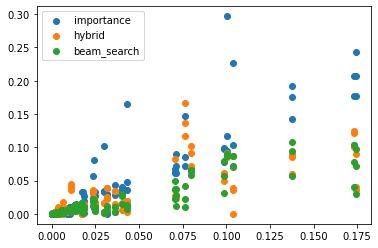

In [45]:
# tdf = df[df.hybrid_num_mc_samples > 800]
tdf = df
plt.scatter(tdf.ground_truth, tdf.importance_sampling_est, label = 'importance')
plt.scatter(tdf.ground_truth, tdf.hybrid_sampling_est, label = 'hybrid')
plt.scatter(tdf.ground_truth, tdf.beam_search_lb, label = 'beam_search')
plt.legend()
# tdf[['hybrid_model_iters','beam_search_model_iters']].head()

In [20]:
df.loc[abs(df.hybrid_model_iters - df.importance_model_iters) > 40,
       ['importance_num_mc_samples','hybrid_num_mc_samples',
       'importance_model_iters','hybrid_model_iters']].head()

,importance_num_mc_samples,hybrid_num_mc_samples,importance_model_iters,hybrid_model_iters
16865,764,1000,1528,1728
16866,821,1000,1642,1903
16867,838,1000,1676,1767
16868,949,1000,1898,1655
16869,942,1000,1884,1818


Text(0.5, 1.0, 'importance')

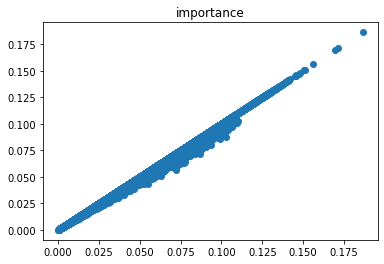

In [16]:
# df = df[df['phase_shifts'] > 10]
# df = df1
ndf = df[df.beam_search_num_beams > 100]
plt.scatter(ndf['ground_truth'],ndf['beam_search_lb'])
# plt.scatter(df['ground_truth'],df['importance_sampling_est'])
# plt.scatter(df['ground_truth'],df['random_sampling_est'])
# plt.ylim((0,1))
plt.title("importance")

In [27]:
df[['importance_est_variance','hybrid_est_variance']].describe()

,importance_est_variance,hybrid_est_variance
count,2.191800e+04,2.191800e+04
mean,3.688037e-05,3.907905e-06
std,6.492985e-04,8.797111e-05
min,2.860333e-20,1.116206e-19
25%,4.422974e-09,1.191007e-09
50%,4.011587e-08,1.700204e-08
75%,3.072154e-07,1.139661e-07
max,4.445925e-02,4.038442e-03


In [21]:
df.isnull().sum()

dataset_name                       0
sequence_id                        0
num_steps                          0
excluded_term                      0
gt_type                            0
ground_truth                       0
random_sampling_est                0
importance_sampling_est            0
hybrid_sampling_est                0
beam_search_lb                     0
random_num_mc_samples              0
importance_num_mc_samples          0
hybrid_num_mc_samples              0
gt_model_iters                     0
random_model_iters                 0
importance_model_iters             0
hybrid_model_iters                 0
beam_search_model_iters            0
random_variance                    0
importance_variance                0
hybrid_variance                    0
gt_true_coverage                   0
gt_restricted_coverage             0
gt_num_beams                       0
beam_search_true_coverage          0
beam_search_restricted_coverage    0
beam_search_num_beams              0
i

In [25]:
# df.to_csv('shakespeare_17-18_20.csv',index=None)
# df.to_csv('moocs_12-13_15.csv',index=None)
# df.to_csv('apps_12-13_15.csv',index=None)
df.to_csv('amazon_12-13_15.csv',index=None)

In [100]:
amazon_dict = read_pkl("/srv/disk00/samshow/amazon/amazon_text_dict.pkl")

In [101]:
data = amazon_dict['text']

In [102]:
data.shape

torch.Size([63844580, 16])

In [109]:
data[0]

tensor([ 0., 16., 16., 16., 11.,  3., 27., 27.,  9.,  9.,  9., 23., 16., 16.,
        16.,  8.])

In [112]:
from tqdm import tqdm
trans = []
for i in tqdm(range(data.shape[0])):
    trans.append(torch.unique_consecutive(data[i,1:]).shape)
    

100%|██████████| 63844580/63844580 [17:23<00:00, 61164.82it/s]  


In [125]:
trans = torch.LongTensor(trans).flatten()

In [126]:
trans.shape

torch.Size([63844580])

In [127]:
write_pkl(trans, "/srv/disask00/samshow/amazon/amazon_phase_trans.pkl")

In [121]:
trans_vals = []
for i in range(1,trans.max()+1):
    trans_vals.append((trans == i).sum().item()/trans.shape[0])

In [123]:
amazon_perc_per_phase_shift = [0.059163910233257073,
 0.020707521296247856,
 0.056485656260876024,
 0.04778584180520884,
 0.07297364944682853,
 0.07653857226408256,
 0.09382401763783238,
 0.10168632952084578,
 0.1102257544806466,
 0.10986890351538063,
 0.09992870185691566,
 0.0774158276238954,
 0.047934671979986396,
 0.020711280425057224,
 0.004749361652939059]